# TOP SECRET! TOTALLY CLASSIFIED! DO NOT DISTRIBUTE OVER EMAIL OR OTHER INSECURE COMMUNICATION PROTOCOLS!! CANVAS OK THO.

## DT2421 ML Programming Challenge (HT20)

In short, the student must build and train a classifier given a labeled dataset and then use it to infer the labels of a given unlabeled evaluation dataset. The student then submits the inferred labels in a specified format, which is  compared to the ground truth. The accuracy of the student's model is proportional to the score they receive. More precisely:

Denote the number of points on this challenge as $N$. In this semester, $N = 18$.

If the student did not follow the instructions: **Points $\leftarrow$ 0**

Otherwise, define the accuracy achieved with majority label classification as $\theta_c$. Define the accuracy achieved with the benchmark as $\theta_b$. Define the theoretical maximum accuracy as $\theta_t$. Finally, denote the student's accuracy as $\theta$.

If $\theta < \theta_c$ 
> **Points $\leftarrow$ 0**

If $\theta_c \le \theta \le \theta_b$ 
> **Points** $\leftarrow (N/2) (\theta-\theta_c)/(\theta_b-\theta_c)$

else 
> **Points** $\leftarrow (N/2) + (N/2) \sqrt{ (\theta - \theta_b)/(\theta_t-\theta_b) }$

The below shows:
$$\theta_t = 0.9385$$
$$\theta_c = 0.4965$$
$$\theta_b = 0.81$$
where the benchmark is achieved by using Naive Bayes.

In [104]:
import numpy as np

np.random.seed(22110)

N = 11000
import pandas as pd
df = pd.DataFrame()

## GROUND TRUTH

Each observation $\mathbf{x}$ has $D=10$ dimensions, where

$$\mathbf{x} \in \mathbb{R}^2 \times [0,1)^2 \times \{\mathrm{T},\mathrm{F}\} \times \{A,B,C,D,E,Fx,F\}\times\mathbb{R}^4.$$

For simplicity, define the dimensions of $\mathbf{x}$ in the order above. Each observation comes from one of $K=3$ classes: 

$$\mathcal{G} = \{\textrm{Atsuto}, \textrm{Bob}, \textrm{Jörg}\}.$$

In [105]:
G = ['Atsuto','Bob','Jörg']

Define the random vector $\mathbf{X} = (X_1, \ldots, X_{10})$ from which $\mathbf{x}$ is sampled, and the random variable $G$ for the classes. We now define the probability distribution 

$$f_\mathbf{X,G}(\mathbf{x},g) = f_\mathbf{X,G}(x_1, \ldots, x_{10},g) = f_\mathbf{X|G}(x_1, \ldots, x_{10}|G=g) P[G=g].$$

### 1. Priors of classes $P[G=g]$

In [106]:
PG = np.array([0.3,0.5,0.2])
s = np.random.multinomial(1,PG,(N,))
groundtruth = np.nonzero(s)[1]
df['y'] = [G[ss] for ss in groundtruth]
print(df)

# the following variable will hold the log probability of each class for each observation
logprobs = np.log(PG[s])

# Compute accuracy by choosing majority class
theta_c = len(np.where(1 == groundtruth)[0])/len(groundtruth)
print("theta_c =",theta_c)

            y
0         Bob
1         Bob
2      Atsuto
3      Atsuto
4         Bob
...       ...
10995     Bob
10996     Bob
10997  Atsuto
10998    Jörg
10999     Bob

[11000 rows x 1 columns]
theta_c = 0.49654545454545457


### 2. $X_1, X_2$ are distributed multivariate Gaussian independent of class

$$f_\mathbf{X|G}(\mathbf{x}|G=g) = f_\mathbf{X',G}(x_3, \ldots, x_{10}|G=g)f_{X_1,X_2}(x_1,x_2)$$

In [107]:
X1X2 = np.random.multivariate_normal([0,0],np.array([[2, -0.5],[-0.5,1]]),N)
df['x1'] = X1X2[:,0]
df['x2'] = X1X2[:,1]
print(df)

            y        x1        x2
0         Bob -0.781026 -0.633751
1         Bob  0.426487 -0.500192
2      Atsuto  1.868170 -0.455652
3      Atsuto -1.800730  0.085353
4         Bob  1.569432 -1.258602
...       ...       ...       ...
10995     Bob -1.782551  1.325771
10996     Bob  0.381429 -0.479494
10997  Atsuto -0.071345 -0.050871
10998    Jörg -0.916444  0.229936
10999     Bob  1.143602  0.019705

[11000 rows x 3 columns]


### 3. With transformation $X'_3,X'_4$ are each distributed uniform in $[a_g,b_g]$ independent of all other dimensions

$$f_\mathbf{X|G}(\mathbf{x}|G=g) = f_\mathbf{X'',G}(x_5, \ldots, x_{10}|G=g,x_3,x_4)f_{X_1,X_2}(x_1,x_2)f_{X_3,X_4|G}(x_3,x_4|G=g)$$


In [108]:
X3=[]
X4=[]
for ii in df['y']:
    if ii=='Atsuto':
        X3.append(np.random.uniform(0,0.75,1))
        X4.append(np.random.uniform(0.2,0.5,1))
    if ii=='Bob':
        X3.append(np.random.uniform(0,0.5,1))
        X4.append(np.random.uniform(0,0.75,1))
    if ii=='Jörg':
        X3.append(np.random.uniform(0.2,0.8,1))
        X4.append(np.random.uniform(0,0.75,1))

X = np.array((X3,X4))
P = np.random.normal(0,1,4).reshape((2,2))
Xp = np.matmul(P,X[:,:,0])
df['x3'] = Xp[0,:]
df['x4'] = Xp[1,:]  
print(df)

# update log probabilities for X3
ix = np.where(X[0,:] > 0.75)
logprobs[ix[0],0] = -np.inf
ix = np.where(X[0,:] <= 0.75)
logprobs[ix[0],0] += np.log(1/0.75)

ix = np.where(X[0,:] > 0.5)
logprobs[ix[0],1] = -np.inf
ix = np.where(X[0,:] <= 0.5)
logprobs[ix[0],1] += np.log(1/0.5)

ix = np.where( (X[0,:] < 0.2) | (X[0,:] > 0.8) )
logprobs[ix[0],2] = -np.inf
ix = np.where( (X[0,:] >= 0.2) & (X[0,:] <= 0.8) )
logprobs[ix[0],2] += np.log(1/0.6)

# update log probabilities for X4
ix = np.where( (X[1,:] < 0.2) | (X[1,:] > 0.5) )
logprobs[ix[0],0] = -np.inf
ix = np.where( (X[1,:] >= 0.2) & (X[1,:] <= 0.5) )
logprobs[ix[0],0] += np.log(1/0.3)

ix = np.where(X[1,:] > 0.75)
logprobs[ix[0],1] = -np.inf
ix = np.where(X[1,:] <= 0.75)
logprobs[ix[0],1] += np.log(1/0.75)

ix = np.where(X[1,:] > 0.75)
logprobs[ix[0],2] = -np.inf
ix = np.where(X[1,:] <= 0.75)
logprobs[ix[0],2] += np.log(1/0.75)


            y        x1        x2        x3        x4
0         Bob -0.781026 -0.633751 -0.036651  0.275172
1         Bob  0.426487 -0.500192  0.006956  0.118172
2      Atsuto  1.868170 -0.455652  0.076578  0.096623
3      Atsuto -1.800730  0.085353 -0.024667  0.140323
4         Bob  1.569432 -1.258602 -0.020919  0.222672
...       ...       ...       ...       ...       ...
10995     Bob -1.782551  1.325771 -0.010371  0.133884
10996     Bob  0.381429 -0.479494 -0.233287  0.236104
10997  Atsuto -0.071345 -0.050871 -0.924294  0.950270
10998    Jörg -0.916444  0.229936 -1.508639  1.385100
10999     Bob  1.143602  0.019705 -0.754776  0.703161

[11000 rows x 5 columns]


### 4. $X_5$ is distributed according to the following rule

$$X_5 = \begin{cases} 1, & x_4 > x_2\\ 0, & \mathrm{else} \end{cases}$$
and so
$$f_\mathbf{X|G}(\mathbf{x}|G=g) = f_\mathbf{X''',G}(x_6, \ldots, x_{10}|G=g,x_3,x_4)f_{X_1,X_2}(x_1,x_2)f_{X_3,X_4|G}(x_3,x_4|G=g)f_{X_5|X_2,X_4}(x_5|x_2,x_4)$$

If $X_5 = 1$, then the observation is "True", otherwise it is "False".

In [109]:
df['x5'] = df['x2']>df['x4']
print(df)

            y        x1        x2        x3        x4     x5
0         Bob -0.781026 -0.633751 -0.036651  0.275172  False
1         Bob  0.426487 -0.500192  0.006956  0.118172  False
2      Atsuto  1.868170 -0.455652  0.076578  0.096623  False
3      Atsuto -1.800730  0.085353 -0.024667  0.140323  False
4         Bob  1.569432 -1.258602 -0.020919  0.222672  False
...       ...       ...       ...       ...       ...    ...
10995     Bob -1.782551  1.325771 -0.010371  0.133884   True
10996     Bob  0.381429 -0.479494 -0.233287  0.236104  False
10997  Atsuto -0.071345 -0.050871 -0.924294  0.950270  False
10998    Jörg -0.916444  0.229936 -1.508639  1.385100  False
10999     Bob  1.143602  0.019705 -0.754776  0.703161  False

[11000 rows x 6 columns]


### 5. $X_6$ is distributed according to the following

$$X_6 = \begin{cases} \mathrm{1}, & 0.9 < x_2 + x_3+x_4 \\ \mathrm{2}, & 0.8 < x_2 + x_3+x_4 \le 0.9\\
\mathrm{3}, & 0.7 < x_2 + x_3+x_4 \le 0.8 \\ \mathrm{4}, & 0.6 < x_2 + x_3+x_4 \le 0.7\\
\mathrm{5}, & 0.5 < x_2 + x_3+x_4 \le 0.6 \\ \mathrm{6}, & 0.4 < x_2 + x_3+x_4 \le 0.5\\
\mathrm{7}, & x_2 + x_3+x_4 \le 0.4
\end{cases}$$

and so
$$f_\mathbf{X|G}(\mathbf{x}|G=g) = f_\mathbf{X'''',G}(x_7, \ldots, x_{10}|G=g,x_3,\ldots,x_6)f_{X_1,X_2}(x_1,x_2)f_{X_3,X_4|G}(x_3,x_4|G=g)f_{X_5|X_2,X_4}(x_5|x_2,x_4)f_{X_6|X_2,X_3,X_4}(x_6|x_2,x_3,x_4)$$

If $X_6 = 1$, then the observation is "A"; if it is $2$, then the observation is "B". And so on to "Fx" and finally "F".

In [110]:
X6 = []
for xx in df['x2']+df['x3']+df['x4']:
    if xx > 0.9:
        X6.append('A')
    elif xx > 0.8:
        X6.append('B')
    elif xx > 0.7:
        X6.append('C')
    elif xx > 0.6:
        X6.append('D')
    elif xx > 0.5:
        X6.append('E')
    elif xx > 0.4:
        X6.append('Fx')
    else:
        X6.append('F')
        
df['x6'] = X6
print(df)

            y        x1        x2        x3        x4     x5 x6
0         Bob -0.781026 -0.633751 -0.036651  0.275172  False  F
1         Bob  0.426487 -0.500192  0.006956  0.118172  False  F
2      Atsuto  1.868170 -0.455652  0.076578  0.096623  False  F
3      Atsuto -1.800730  0.085353 -0.024667  0.140323  False  F
4         Bob  1.569432 -1.258602 -0.020919  0.222672  False  F
...       ...       ...       ...       ...       ...    ... ..
10995     Bob -1.782551  1.325771 -0.010371  0.133884   True  A
10996     Bob  0.381429 -0.479494 -0.233287  0.236104  False  F
10997  Atsuto -0.071345 -0.050871 -0.924294  0.950270  False  F
10998    Jörg -0.916444  0.229936 -1.508639  1.385100  False  F
10999     Bob  1.143602  0.019705 -0.754776  0.703161  False  F

[11000 rows x 7 columns]


### 6. $X_7,X_8$ are distributed multivariate Gaussian depending on class

$$\begin{multline}f_\mathbf{X|G}(\mathbf{x}|G=g) = f_\mathbf{X''''',G}(x_9, x_{10}|G=g,x_3,\ldots,x_8)f_{X_1,X_2}(x_1,x_2)f_{X_3,X_4|G}(x_3,x_4|G=g)\\
f_{X_5|X_2,X_4}(x_5|x_2,x_4)f_{X_6|X_3,X_4}(x_6|x_3,x_4)f_{X_7,X_8|G}(x_7,x_8|G=g)\end{multline}$$


In [111]:
X7=[]
X8=[]
for ii in df['y']:
    if ii=='Atsuto':
        xx = np.random.multivariate_normal([1,1],2*np.eye(2))
    if ii=='Bob':
        xx = np.random.multivariate_normal([-1,-1],0.5*np.eye(2))
    if ii=='Jörg':
        xx = np.random.multivariate_normal([1,0],np.eye(2))

    X7.append(xx[0])
    X8.append(xx[1])
df['x7'] = np.array(X7)
df['x8'] = np.array(X8)     
print(df)

# update log probabilities for X7, X8
from scipy.stats import multivariate_normal
X = np.array((X7,X8)).T
logprobs[:,0] += np.log(multivariate_normal.pdf(X,[1,1],2*np.eye(2)))
logprobs[:,1] += np.log(multivariate_normal.pdf(X,[-1,-1],0.5*np.eye(2)))
logprobs[:,2] += np.log(multivariate_normal.pdf(X,[1,0],np.eye(2)))

            y        x1        x2        x3        x4     x5 x6        x7  \
0         Bob -0.781026 -0.633751 -0.036651  0.275172  False  F -1.857550   
1         Bob  0.426487 -0.500192  0.006956  0.118172  False  F -1.737613   
2      Atsuto  1.868170 -0.455652  0.076578  0.096623  False  F  1.027982   
3      Atsuto -1.800730  0.085353 -0.024667  0.140323  False  F  2.027931   
4         Bob  1.569432 -1.258602 -0.020919  0.222672  False  F -0.433043   
...       ...       ...       ...       ...       ...    ... ..       ...   
10995     Bob -1.782551  1.325771 -0.010371  0.133884   True  A -1.439007   
10996     Bob  0.381429 -0.479494 -0.233287  0.236104  False  F -0.722691   
10997  Atsuto -0.071345 -0.050871 -0.924294  0.950270  False  F  0.216218   
10998    Jörg -0.916444  0.229936 -1.508639  1.385100  False  F -1.377088   
10999     Bob  1.143602  0.019705 -0.754776  0.703161  False  F -0.745080   

             x8  
0      0.226685  
1     -1.610154  
2     -0.923261  
3  


### 7. Finally, $X_9,X_{10}$ are distributed multivariate mixture Gaussian depdendent on class

$$\begin{multline}f_\mathbf{X|G}(\mathbf{x}|G=g) = f_\mathbf{X''''',G}(x_9, x_{10}|G=g,x_3,\ldots,x_8)f_{X_1,X_2}(x_1,x_2)f_{X_3,X_4|G}(x_3,x_4|G=g)\\
f_{X_5|X_2,X_4}(x_5|x_2,x_4)f_{X_6|X_3,X_4}(x_6|x_3,x_4)f_{X_7,X_8|G}(x_7,x_8|G=g)\end{multline}$$

In [112]:
X9=[]
X10=[]
for ii in df['y']:
    if ii=='Atsuto':
        if np.random.uniform() > 0.5:
            xx = np.random.multivariate_normal([2,1],2*np.array([[1,0.2],[0.2,0.7]]))
        else:
            xx = np.random.multivariate_normal([-2,1],np.array([[1,-0.3],[-0.3,1]]))
    if ii=='Bob':
        if np.random.uniform() > 0.75:
            xx = np.random.multivariate_normal([-2,1],np.array([[1,0.4],[0.4,2]]))
        else:
            xx = np.random.multivariate_normal([-2,1],np.array([[2,-0.3],[-0.3,1]]))
    if ii=='Jörg':
        if np.random.uniform() > 0.25:
            xx = np.random.multivariate_normal([-1,2],np.array([[1,0.4],[0.4,2]]))
        else:
            xx = np.random.multivariate_normal([2,-1],np.array([[2,-0.3],[-0.3,1]]))
    X9.append(xx[0])
    X10.append(xx[1])
df['x9'] = np.array(X9)
df['x10'] = np.array(X10)     
print(df)

# update log probabilities for X9, X10
X = np.array((X9,X10)).T
logprobs[:,0] += np.log( 0.5*multivariate_normal.pdf(X,[2,1],2*np.array([[1,0.2],[0.2,0.7]]))+
                       0.5*multivariate_normal.pdf(X,[-2,1],np.array([[1,-0.3],[-0.3,1]])) )
logprobs[:,1] += np.log( 0.25*multivariate_normal.pdf(X,[-2,1],np.array([[1,0.4],[0.4,2]]))+
                       0.75*multivariate_normal.pdf(X,[-2,1],np.array([[2,-0.3],[-0.3,1]])) )
logprobs[:,2] += np.log( 0.25*multivariate_normal.pdf(X,[-1,2],np.array([[1,0.4],[0.4,2]]))+
                       0.75*multivariate_normal.pdf(X,[2,-1],np.array([[2,-0.3],[-0.3,1]])) )

            y        x1        x2        x3        x4     x5 x6        x7  \
0         Bob -0.781026 -0.633751 -0.036651  0.275172  False  F -1.857550   
1         Bob  0.426487 -0.500192  0.006956  0.118172  False  F -1.737613   
2      Atsuto  1.868170 -0.455652  0.076578  0.096623  False  F  1.027982   
3      Atsuto -1.800730  0.085353 -0.024667  0.140323  False  F  2.027931   
4         Bob  1.569432 -1.258602 -0.020919  0.222672  False  F -0.433043   
...       ...       ...       ...       ...       ...    ... ..       ...   
10995     Bob -1.782551  1.325771 -0.010371  0.133884   True  A -1.439007   
10996     Bob  0.381429 -0.479494 -0.233287  0.236104  False  F -0.722691   
10997  Atsuto -0.071345 -0.050871 -0.924294  0.950270  False  F  0.216218   
10998    Jörg -0.916444  0.229936 -1.508639  1.385100  False  F -1.377088   
10999     Bob  1.143602  0.019705 -0.754776  0.703161  False  F -0.745080   

             x8        x9       x10  
0      0.226685 -2.351304  1.420921  

### 8. Compute theoretical maximum accuracy

In [114]:
preds = np.argmax(logprobs,axis=1)
theta_t = len(np.where(preds == groundtruth)[0])/len(groundtruth)
print("theta_t = ",theta_t)

theta_t =  0.9385454545454546


### 9. Save training and evaluation datasets to files in CSV format

Further processing of the training data file includes (done by hand):
- a few observations having a dimension with an order of magnitude larger
- a few observations having '?' in a dimension or two
- a few observations that don't have enough dimensions
- a random line of text

Student should be able to handle these by either inferring values, removing the bad observation, and deleting the text.

In [252]:
df_train = df.iloc[0:1000]
df_eval = df.iloc[1000:]

df_train.to_csv("TrainOnMe_orig.csv",float_format='%2.5f')
df_eval.drop(['y'],axis=1).to_csv("EvaluateOnMe.csv",float_format='%2.5f')
df_eval.to_csv("EvaluationGT.csv",columns=['y'])

### 10.  Let's visualize the training dataset and train and test a few basic classifiers

In [115]:
df2 = pd.DataFrame.copy(df)
df2['y'] = df2['y'].astype('category').cat.codes
df2['x5'] = df2['x5'].astype('category').cat.codes
df2['x6'] = df2['x6'].astype('category').cat.codes

df_train = df2.iloc[0:1000]
df_eval = df2.iloc[1000:]

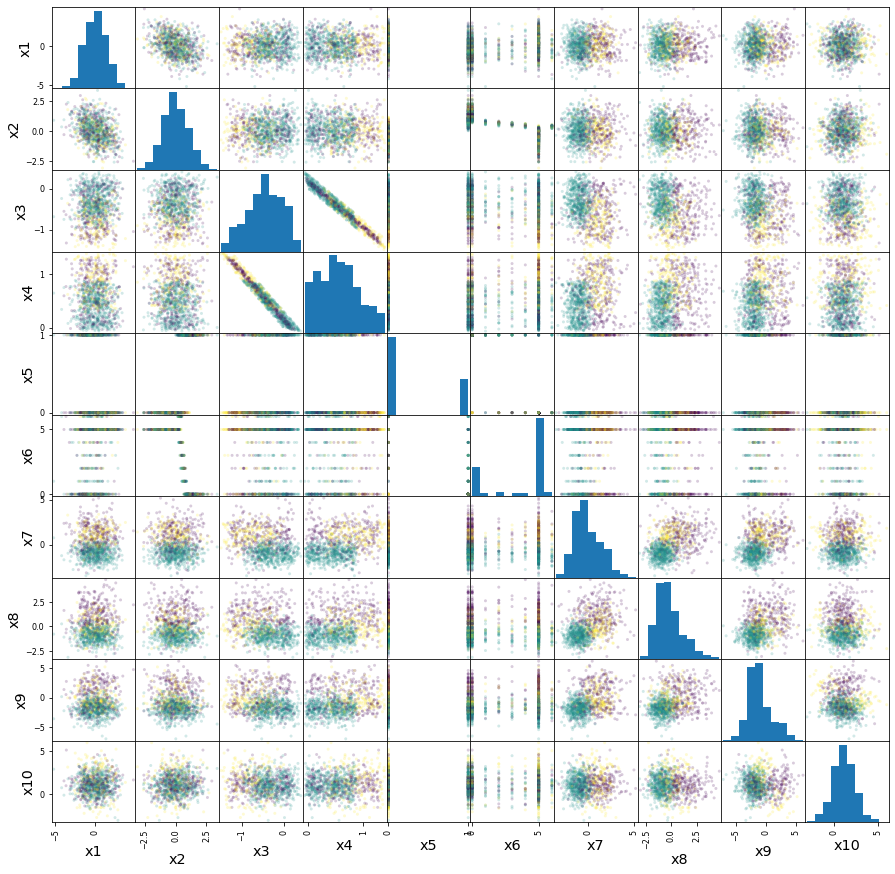

In [116]:
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large','figure.figsize': (15, 15),
          'axes.labelsize': 'x-large','axes.titlesize':'x-large',
         'xtick.labelsize':'x-large','ytick.labelsize':'x-large'}
plt.rcParams.update(params)

pd.plotting.scatter_matrix(df_train.drop(['y'],axis=1), c=df_train['y'], marker='.', alpha=0.2)
plt.draw()

In [117]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['y'],axis=1), df_train['y'], test_size=0.2)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clfLDA = LinearDiscriminantAnalysis(solver='lsqr')
clfLDA.fit(X_train, y_train)
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
clfQDA = QuadraticDiscriminantAnalysis(store_covariance=True)
clfQDA.fit(X_train, y_train)
from sklearn.naive_bayes import GaussianNB
clfNB = GaussianNB()
clfNB.fit(X_train, y_train)

from sklearn.metrics import classification_report
print('LDA:',classification_report(y_test, clfLDA.predict(X_test)))
print('LDA eval:',classification_report(df_eval['y'], clfLDA.predict(df_eval.drop(['y'],axis=1))))

print('QDA:',classification_report(y_test, clfQDA.predict(X_test)))
print('QDA eval:',classification_report(df_eval['y'], clfQDA.predict(df_eval.drop(['y'],axis=1))))

print(' NB:',classification_report(y_test, clfNB.predict(X_test)))
print(' NB eval:',classification_report(df_eval['y'], clfNB.predict(df_eval.drop(['y'],axis=1))))

LDA:               precision    recall  f1-score   support

           0       0.85      0.63      0.73        65
           1       0.88      0.99      0.93       104
           2       0.63      0.71      0.67        31

    accuracy                           0.83       200
   macro avg       0.79      0.78      0.77       200
weighted avg       0.83      0.83      0.82       200

LDA eval:               precision    recall  f1-score   support

           0       0.74      0.65      0.69      3040
           1       0.88      0.99      0.93      4943
           2       0.64      0.56      0.60      2017

    accuracy                           0.80     10000
   macro avg       0.75      0.73      0.74     10000
weighted avg       0.79      0.80      0.79     10000

QDA:               precision    recall  f1-score   support

           0       0.93      0.85      0.89        65
           1       0.94      0.98      0.96       104
           2       0.82      0.87      0.84        31

